# Warsztaty KNDS 28.02.2019
## AdaBoost, czyli adaptative boosting

### Wizualizacja

In [3]:
import numpy as np
import seaborn as sns
from scipy.stats import norm

In [4]:
p = np.arange(0.001,1,0.001)
y1 = p
y10 = 1 - norm.cdf(- 10**0.5 / 2 * (2*p-1)/np.sqrt(p*(1-p)))
y100 = 1 - norm.cdf(- 100**0.5 / 2 * (2*p-1)/np.sqrt(p*(1-p)))
y1000 = 1 - norm.cdf(- 1000**0.5 / 2 * (2*p-1)/np.sqrt(p*(1-p)))
y1000000 = 1 - norm.cdf(- 1000000**0.5 / 2 * (2*p-1)/np.sqrt(p*(1-p)))

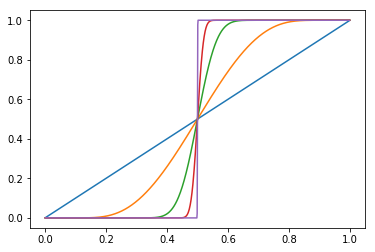

In [8]:
sns.lineplot(p,p)
sns.lineplot(p,y10)
sns.lineplot(p,y100)
sns.lineplot(p,y1000)
sns.lineplot(p,y1000000)

### AdaBoost algorytm

* klasyfikator binarny zwraca 1 i -1
* wagi równe i sumujące się do 1
* dla każdego klasyfikatora:
    * uczymy w sposób ważony na zbiorze uczącym
    * liczymy $y_{pred}$
    * liczymy ważoną stopę błędu $e_i =  \sum w \cdot (y_{pred} != y)$
    * $\alpha_i = 0.5log(\frac{1-e_i}{e_i})$
    * aktualizacja wag: $w:= w \cdot exp(-\alpha_i y_{pred} \cdot y)$
    * normalizacja wag
* $\sum \alpha_i predict(x)$

## AdaBoost implementacja

In [68]:
class AdaBoostKNDS:
    def __init__(self,base_estimator, n_classifiers, **kwargs):
        """
        base_estimator - Class of the base estimator, base estimator must have fit(X,y,weights) method and predict(X) method
        n_classifiers - Number of the base estimators
        kwargs - arguments passed to the base estimator constructor
        """
        self.base_estimator = base_estimator
        self.n_classifiers = n_classifiers
        self.kwargs = kwargs
        
    def fit(self,X,y):
        """
        """
        sample_weight = np.repeat(1/X.shape[0],X.shape[0])
        
        self.clf = [self.base_estimator(**self.kwargs) for i in range(self.n_classifiers)]
        
        self.coef = np.empty(self.n_classifiers)
        
        for i in range(self.n_classifiers):
            
            self.clf[i].fit(X,y,sample_weight)
            y_pred = self.clf[i].predict(X)
            
            weighted_error = np.sum(sample_weight * (y_pred != y))
            self.coef[i] = 0.5 * np.log((1-weighted_error) / float(weighted_error))
            sample_weight = sample_weight * np.exp(-self.coef[i] * AdaBoostKNDS._translate(y_pred) \
                                                   * AdaBoostKNDS._translate(y))
            sample_weight = sample_weight / np.sum(sample_weight)
            
    def _translate(v):
        return 2*v - 1
    
    def predict(self,X):
        result = np.zeros(X.shape[0])
        for i in range(self.n_classifiers):
            result = result + self.coef[i] * AdaBoostKNDS._translate(self.clf[i].predict(X))
        return (result > 0).astype(int)

### Plot decision regions

In [15]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X,y,clf,resolution=0.02):
    """
    The function plots decision regions on 2D plain given the data to plot: matrix X and vector y;
    and trained classifier clf. The data should be standarized.
    """
    
    # setting constants
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # setting frame sizes
    x1_min, x1_max = X[:,0].min() - 0.25, X[:,0].max() + 0.25
    x2_min, x2_max = X[:,1].min() - 0.25, X[:,1].max() + 0.25
    
    # grid
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                         np.arange(x2_min,x2_max,resolution))
    
    # prediction of every point on the grid
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).transpose())
    Z = Z.reshape(xx1.shape)
    
    # filling regions
    plt.contourf(xx1,xx2,Z,alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # displaying points from X
    for idx, cl in  enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl,1],
                   alpha=0.8,c=cmap(idx),
                   marker=markers[idx],
                   label=cl, s=2)

## Testy

In [61]:
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [62]:
cancer = sklearn.datasets.load_breast_cancer()
X = np.array(cancer.data)
y = np.array(cancer.target)
pca = PCA(n_components=2)
stdsc = StandardScaler()

X = pca.fit_transform(X)
X = stdsc.fit_transform(X)

In [85]:
X_train.shape[0]

426

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

### Drzewo decyzyjne

In [69]:
dtc = DecisionTreeClassifier(max_depth=1)
dtc.fit(X_train,y_train)

np.mean(dtc.predict(X_test) == y_test)

0.9090909090909091

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


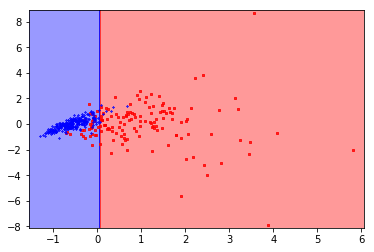

In [70]:
plot_decision_regions(X_train,y_train,dtc)

### AdaBoostKNDS

In [97]:
dict = {'max_depth': 1}

In [98]:
ada = AdaBoostKNDS(DecisionTreeClassifier, n_classifiers=100, **dict)

ada.fit(X_train,y_train)

np.mean(ada.predict(X_test) == y_test)

0.508

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


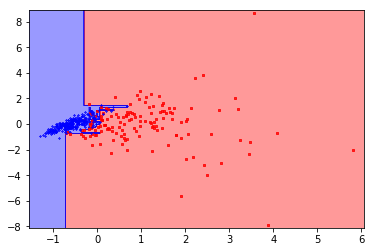

In [83]:
plot_decision_regions(X_train,y_train,ada)

## Dane nieliniowe

In [90]:
X = np.random.randn(10000, 2)
y = np.logical_xor(X[:,0]>=0, X[:,1]<0).astype(int)

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [93]:
dtc.fit(X_train,y_train)

np.mean(dtc.predict(X_test) == y_test)

0.5044

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


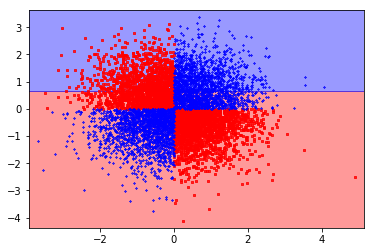

In [94]:
plot_decision_regions(X_train,y_train,dtc)

### AdaBoostKNDS

In [99]:
ada.fit(X_train,y_train)

np.mean(ada.predict(X_test) == y_test)

0.508

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


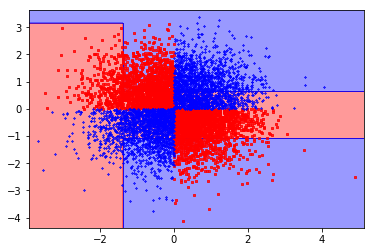

In [100]:
plot_decision_regions(X_train,y_train,ada)

### AdaBoost scikit

In [101]:
from sklearn.ensemble import AdaBoostClassifier

In [102]:
ada_sklearn = AdaBoostClassifier(dtc, n_estimators=100)

ada_sklearn.fit(X_train, y_train)

np.mean(ada_sklearn.predict(X_test) == y_test)

0.4864

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


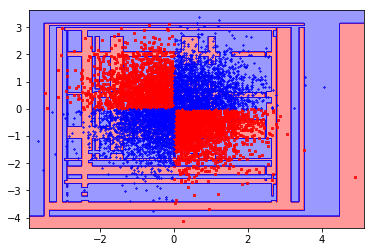

In [103]:
plot_decision_regions(X_train,y_train,ada_sklearn)

Nie da się dać NN z scikit learna

.fit(X,y,sample_weight)
.predict_proba

In [104]:
from sklearn.linear_model import LogisticRegression

In [105]:
lr = LogisticRegression()

In [ ]:
lr.fit()

In [106]:
from sklearn.neural_network import MLPClassifier

In [107]:
mlp = MLPClassifier()

In [108]:
mlp.fit()

TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

In [109]:
from sklearn.svm import SVC

In [110]:
svc = SVC()

In [ ]:
svc.fit()

In [ ]:
ada.fit()

In [112]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [ ]:
gbc = GBC()